# Step 4: Contexts and their generation
Consider the case in which the company cannot observe the type of each customer Ci, but
only the features F1 and F2. Moreover, no information about the edge activation probabilities
and the reward distributions F(Dj, Ci) is known beforehand. The structure of the contexts is
not known beforehand and needs to be learned from data. Important remark: the learner
does not know how many contexts there are, while it can only observe the features and data
associated with the features. Apply the UCB and TS algorithms (as in Step 3) paired with a
context generation algorithm, reporting the plots with the average (over a sufficiently large
number of runs) value and standard deviation of the cumulative regret, cumulative reward,
instantaneous regret, and instantaneous reward. Apply the context generation algorithms
every two weeks of the simulation. Compare the performance of the designed algorithm with
the one in Step 3 (that can observe the context).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.cluster import KMeans

In [2]:
class Learner:

    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)
        self.t += 1

In [3]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)

    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (
                self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            # n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)

    def expectations(self):
        return self.empirical_means

In [4]:
class TSLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.beta_parameters = np.ones((n_arms, 2))
        self.means = np.zeros(n_arms)  # Initialize the means array with zeros

    def pull_arm(self):
        idx = np.argmax(np.random.beta(self.beta_parameters[:, 0], self.beta_parameters[:, 1]))
        return idx

    def update(self, pulled_arm, reward):
        self.t += 1
        self.update_observations(pulled_arm, reward)
        self.beta_parameters[pulled_arm, 0] = self.beta_parameters[pulled_arm, 0] + reward
        self.beta_parameters[pulled_arm, 1] = self.beta_parameters[pulled_arm, 1] + 1.0 - reward
        for arm in range(self.n_arms):
            alpha = self.beta_parameters[arm, 0]
            beta = self.beta_parameters[arm, 1]
            if alpha == 1 and beta == 1:
                self.means[arm] = 0
            else:
                self.means[arm] = alpha / (alpha + beta)

    def expectations(self):
        return self.means

In [5]:
class Environment:
    def __init__(self, probabilities):
        self.probabilities = np.array(probabilities).flatten()
        self.n_arms = len(self.probabilities)
        
    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward
    
    def get_features(self):
        # Generate observed features randomly from a normal distribution
        # For this example, let's assume there are 2 features for each arm
        n_features = 2
        features = np.random.normal(0, 1, (self.n_arms, n_features))
        return features


In [6]:
class ContextualUCBLearner(UCBLearner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.contexts = []
        
    def update_contexts(self, contexts):
        self.contexts = contexts
        
class ContextualTSLearner(TSLearner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.contexts = []
        
    def update_contexts(self, contexts):
        self.contexts = contexts

class ContextGenerator:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
        self.kmeans = KMeans(n_clusters=n_clusters)

    def fit(self, features):
        self.kmeans.fit(features)

    def predict(self, features):
        return self.kmeans.predict(features)


### Parameters Set Up

In [7]:
# Define the number of clusters for context generation
n_clusters = 5

# Create an instance of the ContextGenerator class
context_generator = ContextGenerator(n_clusters=n_clusters)

# Define the number of arms
n_arms = 30

# Define the time horizon
T = 365

In [8]:
# Create an instance of the Environment class
env = Environment(probabilities=np.random.rand(n_arms))

# Create instances of the ContextualUCBLearner and ContextualTSLearner classes
ucb_learner = ContextualUCBLearner(n_arms=n_arms)
ts_learner = ContextualTSLearner(n_arms=n_arms)

# Define the time interval for context generation
context_interval = 14

# Simulate the contextual bandit problem
for t in tqdm(range(1, T+1)):
    # Get the features associated with the arms
    features = env.get_features()

    # Update the contexts every two weeks
    if t % context_interval == 0:
        context_generator.fit(features)
        contexts = context_generator.predict(features)
        ucb_learner.update_contexts(contexts)
        ts_learner.update_contexts(contexts)

    # Pull the arms and update the learners
    pulled_arm_ucb = ucb_learner.pull_arm()
    reward_ucb = env.round(pulled_arm_ucb)
    ucb_learner.update(pulled_arm_ucb, reward_ucb)

    pulled_arm_ts = ts_learner.pull_arm()
    reward_ts = env.round(pulled_arm_ts)
    ts_learner.update(pulled_arm_ts, reward_ts)

100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:01<00:00, 289.86it/s]


In [9]:
# Define the optimal arm
optimal_arm = np.argmax(env.probabilities)

# Define the number of runs for averaging
n_runs = 100

# Define arrays to store the performance metrics
cumulative_regret_ucb = np.zeros(T)
cumulative_reward_ucb = np.zeros(T)
instantaneous_regret_ucb = np.zeros(T)
instantaneous_reward_ucb = np.zeros(T)

cumulative_regret_ts = np.zeros(T)
cumulative_reward_ts = np.zeros(T)
instantaneous_regret_ts = np.zeros(T)
instantaneous_reward_ts = np.zeros(T)



In [10]:
# Define arrays to store the performance metrics for the clairvoyant
cumulative_reward_clairvoyant = np.zeros(T)
instantaneous_reward_clairvoyant = np.zeros(T)

# Simulate the contextual bandit problem for multiple runs
for run in tqdm(range(n_runs)):
    ucb_learner = ContextualUCBLearner(n_arms=n_arms)
    ts_learner = ContextualTSLearner(n_arms=n_arms)
    context_generator = ContextGenerator(n_clusters=n_clusters)
    for t in range(1, T+1):
        features = env.get_features()
        if t % context_interval == 0:
            context_generator.fit(features)
            contexts = context_generator.predict(features)
            ucb_learner.update_contexts(contexts)
            ts_learner.update_contexts(contexts)

        pulled_arm_ucb = ucb_learner.pull_arm()
        reward_ucb = env.round(pulled_arm_ucb)
        ucb_learner.update(pulled_arm_ucb, reward_ucb)

        pulled_arm_ts = ts_learner.pull_arm()
        reward_ts = env.round(pulled_arm_ts)
        ts_learner.update(pulled_arm_ts, reward_ts)

        optimal_reward = env.round(optimal_arm)

        cumulative_regret_ucb[t-1] += optimal_reward - reward_ucb
        cumulative_reward_ucb[t-1] += reward_ucb
        instantaneous_regret_ucb[t-1] += optimal_reward - reward_ucb
        instantaneous_reward_ucb[t-1] += reward_ucb

        cumulative_regret_ts[t-1] += optimal_reward - reward_ts
        cumulative_reward_ts[t-1] += reward_ts
        instantaneous_regret_ts[t-1] += optimal_reward - reward_ts
        instantaneous_reward_ts[t-1] += reward_ts

        cumulative_reward_clairvoyant[t-1] += optimal_reward
        instantaneous_reward_clairvoyant[t-1] += optimal_reward



100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:50<00:00,  1.10s/it]


In [11]:
# Calculate the average and standard deviation of the performance metrics
cumulative_regret_ucb /= n_runs
cumulative_reward_ucb /= n_runs
instantaneous_regret_ucb /= n_runs
instantaneous_reward_ucb /= n_runs

cumulative_regret_ts /= n_runs
cumulative_reward_ts /= n_runs
instantaneous_regret_ts /= n_runs
instantaneous_reward_ts /= n_runs

cumulative_reward_clairvoyant /= n_runs
instantaneous_reward_clairvoyant /= n_runs

# Calculate standard deviation for instantaneous rewards
std_instantaneous_reward_ucb = np.std(instantaneous_reward_ucb)
std_instantaneous_reward_ts = np.std(instantaneous_reward_ts)

# Calculate standard deviation for instantaneous regrets
std_instantaneous_regret_ucb = np.std(instantaneous_regret_ucb)
std_instantaneous_regret_ts = np.std(instantaneous_regret_ts)

# Calculate the cumulative reward for the clairvoyant
cumulative_reward_clairvoyant = np.cumsum(instantaneous_reward_clairvoyant)
cumulative_reward_clairvoyant = np.ones(T) * cumulative_reward_clairvoyant[-1]

#Calculate instantaneous rewards for clairvoyant
instantaneous_reward_clairvoyant = np.ones(T)*instantaneous_reward_clairvoyant[-1]

# Calculate the cumulative rewards for UCB and TS
cumulative_reward_ucb = np.cumsum(instantaneous_reward_ucb)
cumulative_reward_ts = np.cumsum(instantaneous_reward_ts)

#Calculate the cumulative regrets for UCB and TS
cumulative_regret_ucb = np.cumsum(instantaneous_regret_ucb)
cumulative_regret_ts = np.cumsum(instantaneous_regret_ts)

# Print the rewards, regrets, and standard deviations
print("UCB Instantaneous Reward:", instantaneous_reward_ucb[-1])
print("UCB Cumulative Reward:", cumulative_reward_ucb[-1])
print("UCB Instantaneous Regret:", instantaneous_regret_ucb[-1])
print("UCB Cumulative Regret:", cumulative_regret_ucb[-1])
print("UCB Standard Deviation:", std_instantaneous_reward_ucb)

print("TS Instantaneous Reward:", instantaneous_reward_ts[-1])
print("TS Cumulative Reward:", cumulative_reward_ts[-1])
print("TS Instantaneous Regret:", instantaneous_regret_ts[-1])
print("TS Cumulative Regret:", cumulative_regret_ts[-1])
print("TS Standard Deviation:", std_instantaneous_reward_ts)




UCB Instantaneous Reward: 0.62
UCB Cumulative Reward: 226.39000000000004
UCB Instantaneous Regret: 0.37
UCB Cumulative Regret: 132.30999999999995
UCB Standard Deviation: 0.10846472576301967
TS Instantaneous Reward: 0.94
TS Cumulative Reward: 322.5300000000002
TS Instantaneous Regret: 0.05
TS Cumulative Regret: 36.17000000000004
TS Standard Deviation: 0.13000161957505513


In [12]:
#Calculate avg values to insert in plots
instantaneous_regret_ucb_avg = np.mean(instantaneous_regret_ucb)
instantaneous_reward_ucb_avg = np.mean(instantaneous_reward_ucb)
instantaneous_regret_ts_avg = np.mean(instantaneous_regret_ts)
instantaneous_reward_ts_avg = np.mean(instantaneous_reward_ts)

### Plot the performance metrics


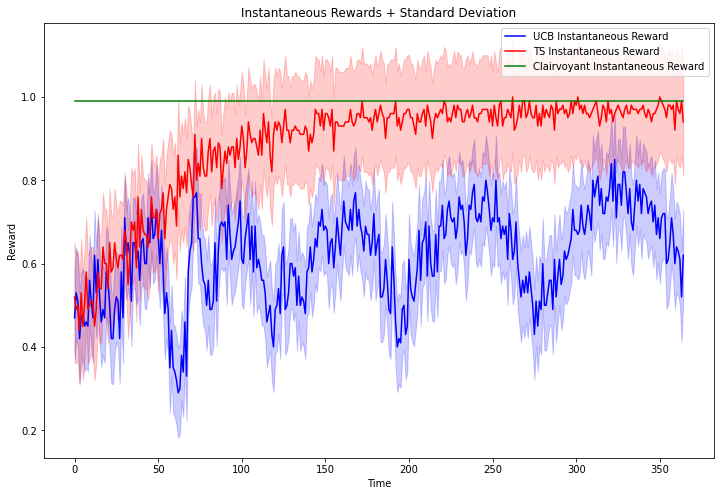

In [13]:

#Instantaneous Reward + std.dev
plt.figure(figsize=(12, 8))
plt.plot(instantaneous_reward_ucb, label='UCB Instantaneous Reward', color='blue')
plt.plot(instantaneous_reward_ts, label='TS Instantaneous Reward', color='red')
plt.plot(instantaneous_reward_clairvoyant, label='Clairvoyant Instantaneous Reward', color='green')
plt.fill_between(range(T), instantaneous_reward_ucb - std_instantaneous_reward_ucb, instantaneous_reward_ucb + std_instantaneous_reward_ucb, alpha=0.2, color='blue')
plt.fill_between(range(T), instantaneous_reward_ts - std_instantaneous_reward_ts, instantaneous_reward_ts + std_instantaneous_reward_ts, alpha=0.2, color='red')
plt.xlabel('Time')
plt.ylabel('Reward')
plt.legend()
plt.title('Instantaneous Rewards + Standard Deviation')
plt.show()


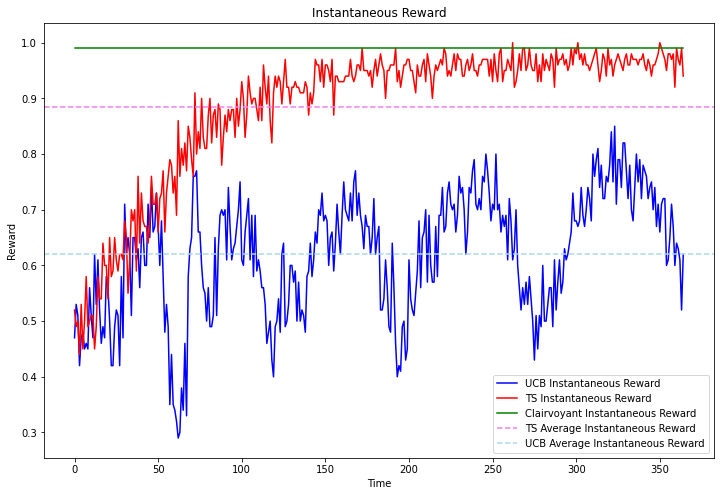

In [14]:
#Instantaneous Reward
plt.figure(figsize=(12, 8))
plt.plot(instantaneous_reward_ucb, label='UCB Instantaneous Reward', color='blue')
plt.plot(instantaneous_reward_ts, label='TS Instantaneous Reward', color='red')
plt.plot(instantaneous_reward_clairvoyant, label='Clairvoyant Instantaneous Reward', color='green')
plt.axhline(y=instantaneous_reward_ts_avg, color='violet', linestyle='--', label='TS Average Instantaneous Reward')
plt.axhline(y=instantaneous_reward_ucb_avg, color='lightblue', linestyle='--', label='UCB Average Instantaneous Reward')
plt.xlabel('Time')
plt.ylabel('Reward')
plt.legend()
plt.title('Instantaneous Reward')
plt.show()


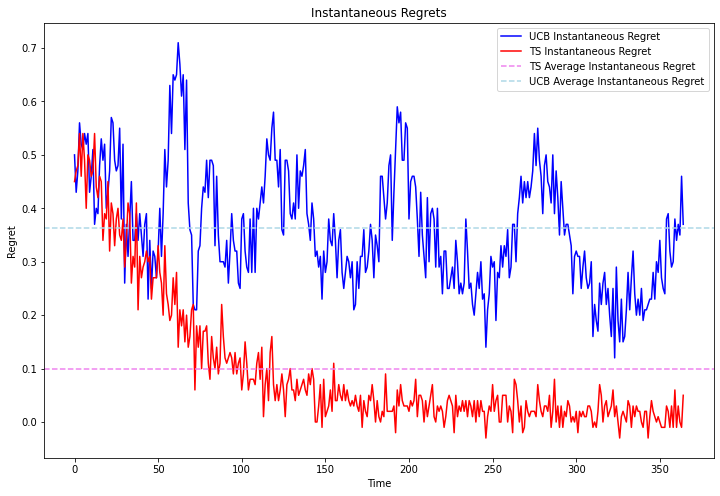

In [15]:
#Instantaneous Regret 
plt.figure(figsize=(12, 8))
plt.plot(instantaneous_regret_ucb, label='UCB Instantaneous Regret', color='blue')
plt.plot(instantaneous_regret_ts, label='TS Instantaneous Regret', color='red')
plt.axhline(y=instantaneous_regret_ts_avg, color='violet', linestyle='--', label='TS Average Instantaneous Regret')
plt.axhline(y=instantaneous_regret_ucb_avg, color='lightblue', linestyle='--', label='UCB Average Instantaneous Regret')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.legend()
plt.title('Instantaneous Regrets')
plt.show()


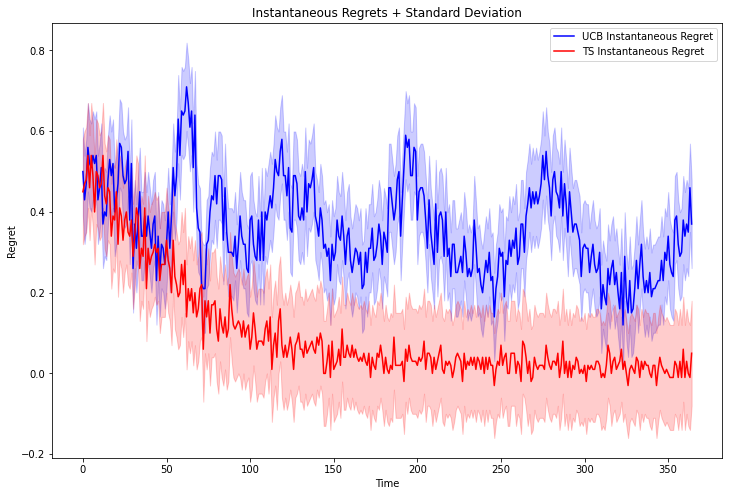

In [16]:
#Instantaneous Regret + std.dev
plt.figure(figsize=(12, 8))
plt.plot(instantaneous_regret_ucb, label='UCB Instantaneous Regret', color='blue')
plt.plot(instantaneous_regret_ts, label='TS Instantaneous Regret', color='red')
plt.fill_between(range(T), instantaneous_regret_ucb - std_instantaneous_regret_ucb, instantaneous_regret_ucb + std_instantaneous_regret_ucb, alpha=0.2, color='blue')
plt.fill_between(range(T), instantaneous_regret_ts - std_instantaneous_regret_ts, instantaneous_regret_ts + std_instantaneous_regret_ts, alpha=0.2, color='red')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.legend()
plt.title('Instantaneous Regrets + Standard Deviation')
plt.show()


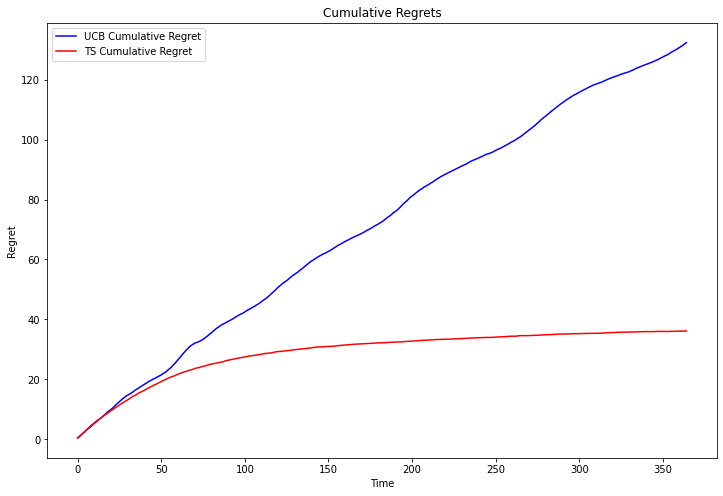

In [17]:
#Cumulative Regret
plt.figure(figsize=(12, 8))
plt.plot(cumulative_regret_ucb, label='UCB Cumulative Regret', color='blue')
plt.plot(cumulative_regret_ts, label='TS Cumulative Regret', color='red')
plt.xlabel('Time')
plt.ylabel('Regret')
plt.legend()
plt.title('Cumulative Regrets')
plt.show()

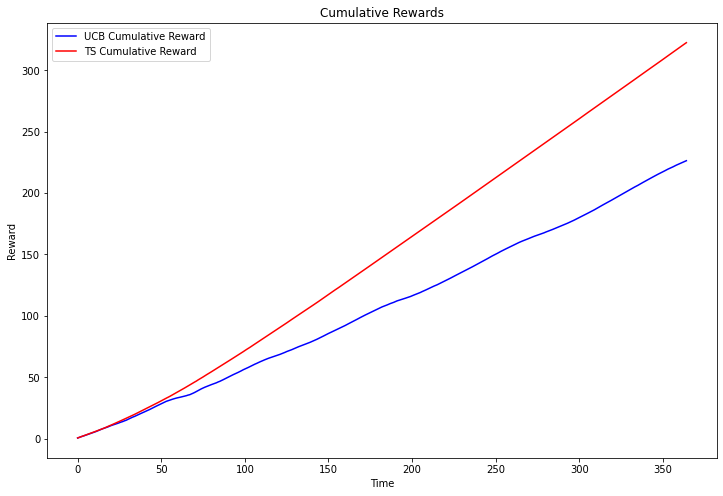

In [18]:
#Cumulative rewards
plt.figure(figsize=(12, 8))
plt.plot(cumulative_reward_ucb, label='UCB Cumulative Reward', color='blue')
plt.plot(cumulative_reward_ts, label='TS Cumulative Reward', color='red')
plt.xlabel('Time')
plt.ylabel('Reward')
plt.legend()
plt.title('Cumulative Rewards')
plt.show()